# Ref: 
https://analyticsindiamag.com/gluonts-pytorchts-for-time-series-forecasting/

# Plot 

In [ ]:
from fund_price_loader import NAV_DIR
from fund_price_loader import load_dataset

In [ ]:
import os
from gluonts.dataset.util import to_pandas


nav_files = os.listdir(NAV_DIR)
file_path = os.path.join(NAV_DIR, nav_files[800])
print(f"file_path: {file_path}")
dataset = load_dataset(file_path)
to_pandas(list(dataset)[0]).plot(linewidth=2)

In [ ]:
from gluonts.model import prophet
predictor = prophet.ProphetPredictor(
    freq="D", prediction_length=100)
predictions = predictor.predict(dataset)
for entry, forecast in zip(dataset, predictions):
    to_pandas(entry).plot(linewidth=2)
    forecast.plot(color='g', prediction_intervals=[50.0, 90.0])

# Evaluation 

- split Train and Test Dataset 
- calculate RMSE

In [5]:
import warnings
warnings.filterwarnings('ignore')
import os
from fund_price_loader import NAV_DIR
from gluonts.dataset.util import to_pandas

nav_files = os.listdir(NAV_DIR)
file_path = os.path.join(NAV_DIR, nav_files[800])

In [6]:
from fund_price_loader import load_split_dataset
from datetime import datetime
train, test = load_split_dataset(file_path, datetime(year=2021, month=5, day=30))

<AxesSubplot:>

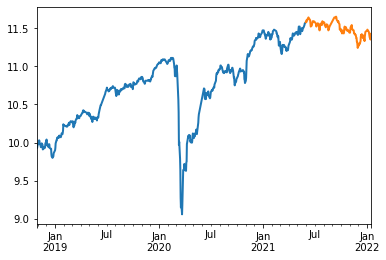

In [7]:
to_pandas(list(train)[0]).plot(linewidth=2)
to_pandas(list(test)[0]).plot(linewidth=2)

In [8]:
from evaluator import evaluation
from gluonts.model import prophet

evaluation(prophet.ProphetPredictor, train, test, verbose=False)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.44442803405895076